# Term 7 project: Inventory management
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [1]:
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')


sku_dataset_dir = r'./SKU110K_fixed'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.10.0
Num GPUs Available:  0


## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [2]:

CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [3]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=32):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    if subset == 'train':
        df = df[:3000]
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, subset,image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset



## Load data

In [4]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 32  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)

print(val_data)

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>


## Visualise data

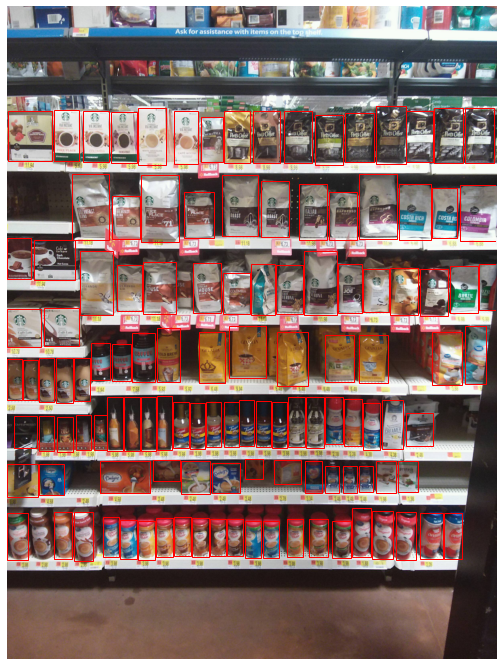

In [5]:
data_num, set = 0, 'test' 
image_num = rf'./SKU110K_fixed/images/{set}/{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv(rf'./SKU110K_fixed/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Train

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers.experimental import preprocessing

In [7]:
from tensorflow.keras.applications import ResNet50V2
base_model = ResNet50V2(weights='imagenet',include_top=False)
base_model.trainable = False

model = models.Sequential([
    Input(shape=(416, 233, 3)), 
    preprocessing.Resizing(224, 224, interpolation='nearest'),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='relu')  # 4 values for bounding box (x, y, width, height)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

model.fit(train_data, epochs=1, validation_data=val_data)

eval_results = model.evaluate(val_data)

29/29 [==============================] - 31s 1s/step - loss: 7.3651


2023-11-01 18:43:41.988432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
377/377 [==============================] - ETA: 0s - loss: 7.3420
2023-11-01 18:54:19.022784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
377/377 [==============================] - 686s 2s/step - loss: 7.3420 - val_loss: 7.2577
29/29 [==============================] - 46s 2s/step - loss: 7.2577
12 min 13.9 seconds

In [10]:
results = model.predict(test_data)
print(results[:10])


135/135 [==============================] - 316s 2s/step
[[1.43481939e-21 1.07405828e-25 1.00000000e+00 1.00000000e+00]
 [3.39454078e-14 4.25868163e-22 1.00000000e+00 1.00000000e+00]
 [5.04824907e-30 2.29487089e-12 1.00000000e+00 1.00000000e+00]
 [7.09287562e-08 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [6.64979946e-11 2.87624776e-14 1.00000000e+00 1.00000000e+00]
 [1.15268785e-32 2.08435653e-20 1.00000000e+00 1.00000000e+00]
 [3.65479678e-01 4.59483892e-01 9.99750316e-01 9.89103138e-01]
 [1.24511300e-31 3.72749689e-26 1.00000000e+00 9.99984622e-01]
 [2.39798242e-12 3.14236915e-16 1.00000000e+00 9.99999344e-01]
 [3.60881852e-04 7.05495899e-24 1.00000000e+00 1.00000000e+00]]


In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the VGG16 layers

model = models.Sequential([
    Input(shape=(416, 233, 3)), 
    preprocessing.Resizing(224, 224, interpolation='bilinear'),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(train_data, epochs=1, validation_data=val_data)

eval_results = model.evaluate(val_data)

print("Loss on validation data:", eval_results)

results = model.predict(test_data)
print(results[:10])

29/29 [==============================] - 67s 2s/step - loss: 0.2876
Loss on validation data: 0.2875899076461792
135/135 [==============================] - 318s 2s/step
[[1.43481939e-21 1.07405828e-25 1.00000000e+00 1.00000000e+00]
 [3.39454078e-14 4.25868163e-22 1.00000000e+00 1.00000000e+00]
 [5.04824907e-30 2.29487089e-12 1.00000000e+00 1.00000000e+00]
 [7.09287562e-08 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [6.64979946e-11 2.87624776e-14 1.00000000e+00 1.00000000e+00]
 [1.15268785e-32 2.08435653e-20 1.00000000e+00 1.00000000e+00]
 [3.65479678e-01 4.59483892e-01 9.99750316e-01 9.89103138e-01]
 [1.24511300e-31 3.72749689e-26 1.00000000e+00 9.99984622e-01]
 [2.39798242e-12 3.14236915e-16 1.00000000e+00 9.99999344e-01]
 [3.60881852e-04 7.05495899e-24 1.00000000e+00 1.00000000e+00]]
